### Predict 2 meter temperature with sea surface temperature using deep learning and evaluate the predictions with simple regression results
This notebook shows how to build a workflow of data driven forecasting using machine learning with `s2spy` & `lilio` packages. It highlights how these packages could facilitate (sub)seasonal forecasts with deep learning and creating baseline forecasts for evaluation.<br>

We will predict temperature in US at seasonal time scales using ERA5 dataset with a LSTM network and evaluate the forecasts against those from linear regression (Ridge). <br>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (the data has been processed)
- Map the calendar to the data (`lilio`)
- Train-test split (70%/30%)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Dimensionality reduction and model training, with cross-validation (`lilio` & `scikit-learn`)

In [1]:
import lilio
import numpy as np
import time as tt
import wandb
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch.autograd import Variable

#### 1. Prepare data for data-driven forecasting

In this section, we build a data pipeline to preprocess and resample data with `s2spy` & `lilio`. <br>
We will see how `lilio` can help us manage and aggregate data with a user-defiend `calendar`. Simple data preprocessing will be achieved using `s2spy`.<br>
By following these steps, the raw input data will be ready for your data-driven forecasting, including a deep learning recipe and a regression-based workflow.

##### Define a calendar with `lilio` to specify time range for targets and precursors.

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="20d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "20d", gap="10d", n=periods_of_interest)

In [3]:
# check calendar
calendar

Calendar(
    anchor='08-01',
    allow_overlap=True,
    mapping=None,
    intervals=[
        Interval(role='target', length='20d', gap='0d'),
        Interval(role='precursor', length='20d', gap='10d'),
        Interval(role='precursor', length='20d', gap='10d'),
        Interval(role='precursor', length='20d', gap='10d'),
        Interval(role='precursor', length='20d', gap='10d'),
        Interval(role='precursor', length='20d', gap='10d'),
        Interval(role='precursor', length='20d', gap='10d'),
        Interval(role='precursor', length='20d', gap='10d'),
        Interval(role='precursor', length='20d', gap='10d')
    ]
)

In [4]:
# load example data
data_folder = '~/AI4S2S/data'
precursor_field = xr.open_dataset(Path(data_folder, 'sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc'))
target_field = xr.open_dataset(Path(data_folder,'tf5_nc5_dendo_80d77.nc'))

##### Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

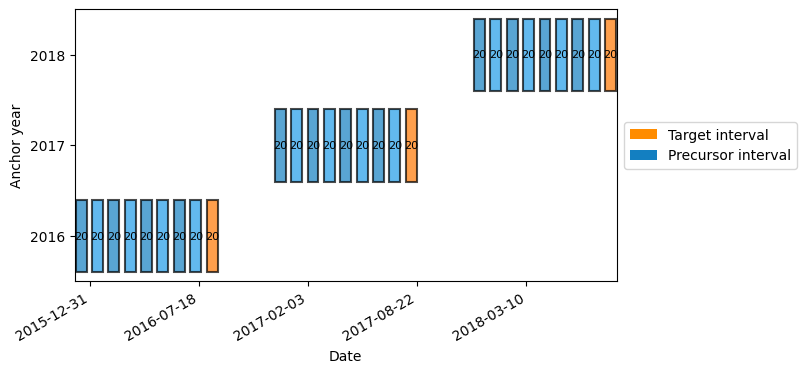

In [5]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [6]:
calendar.show()[:3]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2018,"[2017-12-04, 2017-12-24)","[2018-01-03, 2018-01-23)","[2018-02-02, 2018-02-22)","[2018-03-04, 2018-03-24)","[2018-04-03, 2018-04-23)","[2018-05-03, 2018-05-23)","[2018-06-02, 2018-06-22)","[2018-07-02, 2018-07-22)","[2018-08-01, 2018-08-21)"
2017,"[2016-12-04, 2016-12-24)","[2017-01-03, 2017-01-23)","[2017-02-02, 2017-02-22)","[2017-03-04, 2017-03-24)","[2017-04-03, 2017-04-23)","[2017-05-03, 2017-05-23)","[2017-06-02, 2017-06-22)","[2017-07-02, 2017-07-22)","[2017-08-01, 2017-08-21)"
2016,"[2015-12-05, 2015-12-25)","[2016-01-04, 2016-01-24)","[2016-02-03, 2016-02-23)","[2016-03-04, 2016-03-24)","[2016-04-03, 2016-04-23)","[2016-05-03, 2016-05-23)","[2016-06-02, 2016-06-22)","[2016-07-02, 2016-07-22)","[2016-08-01, 2016-08-21)"


##### Train-validate-test split based on the anchor years (70%/15%/15% split)

In [7]:
# get 70% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.7)
test_samples = round(len(years) * 0.15)
start_year = years[0]

##### Fit preprocessor with training samples and preprocess data
In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

In [8]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(precursor_field.sel(time=slice(str(start_year),
                                                str(start_year + train_samples - 1))))

In [9]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

##### Resample data to the calendar

In [10]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [11]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['ts'].sel(cluster=3)

#### 2. Build workflow to train a LSTM network for forecasting
In this section, we will start building a LSTM network using pytorch and train our neural network to forecast 2 meter temperture with sea surface temperature.

To begin with, We need to convert our data to `torch.Tensor`.

In [12]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude)
lon_precursor = len(precursor_field_sel.longitude)

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

We split our data into train/cross-validate/test sets.

In [13]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

##### Build LSTM model
Build a LSTM model with `nn.LSTM` module.

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1,
                 batch_size=1, num_layers=1):
        """
        Initialize the LSTM model in Pytorch and specify the basic model structure.
        Expected input timeseries dimension [batch_size, sequence, channels]
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim,
                            num_layers = num_layers, batch_first = True)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def init_hidden(self):
        """Initialize hidden state with random values."""
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, input):
        (h_0, c_0) = self.init_hidden()
        x, _ = self.lstm(input, (h_0, c_0))
        x = self.linear(x)
            
        return x

##### Hyper-parameter tuning with W&B
We use Weight&Biases to monitor the training process. It is very simple to integrate it into your workflow and more information about how to set it up can be found at https://docs.wandb.ai/quickstart. <br>

Let's first take a look at the system information.

In [15]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 2.0.1+cu117
Is CUDA available? False
Device to be used for computation: cpu


Define hyperparameters, initialize config for wandb and syncronize training information with W&B server.

In [16]:
# call weights & biases service
wandb.login()

# define hyperparameters and the 
hyperparameters = dict(
    epoch = 100,
    input_dim = lat_precursor*lon_precursor,
    hidden_dim = lat_precursor*lon_precursor*2,
    output_dim = 1,
    batch_size = 3, 
    num_layers = 4,
    learning_rate = 0.01,
    dataset = 'Weather',
    architecture = 'LSTM'
)

# initialize weights & biases service
mode = 'online'
#mode = 'disabled'
wandb.init(config=hyperparameters, project='test-LSTM-ridge', entity='ai4s2s', mode=mode)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: git-yang (ai4s2s). Use `wandb login --relogin` to force relogin


Create data loaders with chosen batch size. 

In [17]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

##### Initialize and train model
Create model using specified hyperparameter. Initialize model and choose loss function and optimizer.

In [18]:
# Initialize model
model = LSTM(input_dim = config["input_dim"],
             hidden_dim = config["hidden_dim"],
             output_dim = config["output_dim"], 
             batch_size = config["batch_size"], 
             num_layers = config["num_layers"]
)
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 LSTM(
  (lstm): LSTM(65, 130, num_layers=4, batch_first=True)
  (linear): Linear(in_features=130, out_features=1, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


[]

Start the training and cross validation loop.

In [19]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch) # we only need the last instance from output sequence
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
              f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch)
            loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

Epoch : 0 [0/27(0%)]	Loss: 2.165582
Epoch : 0 [3/27(11%)]	Loss: 2.707063
Epoch : 0 [6/27(22%)]	Loss: 3.939999
Epoch : 0 [9/27(33%)]	Loss: 3.234633
Epoch : 0 [12/27(44%)]	Loss: 8.445068
Epoch : 0 [15/27(56%)]	Loss: 2.638636
Epoch : 0 [18/27(67%)]	Loss: 0.399618
Epoch : 0 [21/27(78%)]	Loss: 1.214677
Epoch : 0 [24/27(89%)]	Loss: 6.242445
Epoch : 1 [0/27(0%)]	Loss: 2.000005
Epoch : 1 [3/27(11%)]	Loss: 2.992116
Epoch : 1 [6/27(22%)]	Loss: 4.789081
Epoch : 1 [9/27(33%)]	Loss: 0.480854
Epoch : 1 [12/27(44%)]	Loss: 3.631541
Epoch : 1 [15/27(56%)]	Loss: 3.119281
Epoch : 1 [18/27(67%)]	Loss: 3.124379
Epoch : 1 [21/27(78%)]	Loss: 0.219105
Epoch : 1 [24/27(89%)]	Loss: 5.125325
Epoch : 2 [0/27(0%)]	Loss: 4.415288
Epoch : 2 [3/27(11%)]	Loss: 5.862941
Epoch : 2 [6/27(22%)]	Loss: 9.001224
Epoch : 2 [9/27(33%)]	Loss: 0.388244
Epoch : 2 [12/27(44%)]	Loss: 4.476913
Epoch : 2 [15/27(56%)]	Loss: 2.381039
Epoch : 2 [18/27(67%)]	Loss: 0.078652
Epoch : 2 [21/27(78%)]	Loss: 0.732189
Epoch : 2 [24/27(89%)]	Loss

Now let's check the training loss and validation loss.

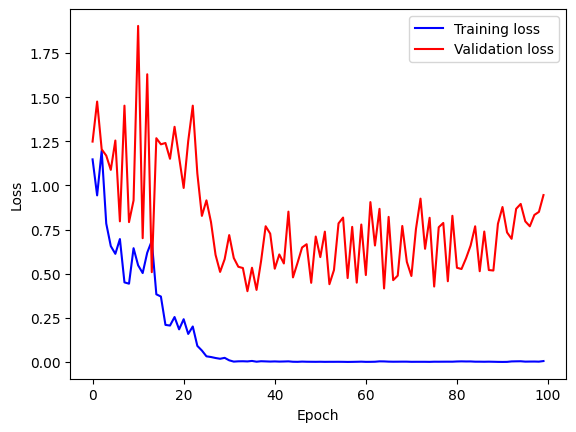

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Evaluate model
Now we can evaluate our model with testing set and compare the predictions with the ground truth.

In [21]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = Variable(X_batch).to(device)
    var_y_batch = Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(output.squeeze().cpu().detach().numpy()[:,-1])
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

testing_loss,▁█
train_loss,▂▃█▅▃▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▆▅▄█▅▄▃▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing_loss,2.98037
train_loss,0.00308
validation_loss,0.50709


Plot the predictions versus ground truth.

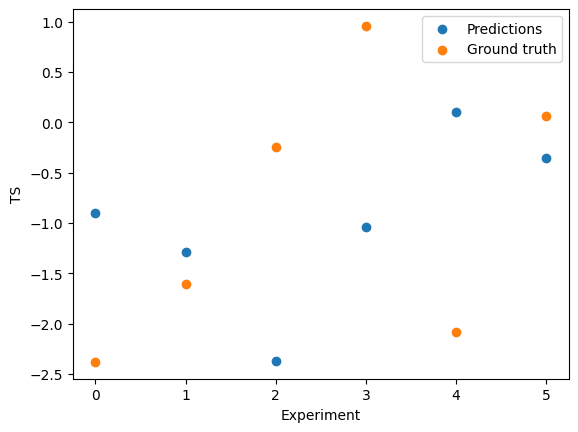

In [22]:
ground_truth = test_y_torch.squeeze().numpy()

fig = plt.figure()
instances = np.arange(len(np.concatenate(predictions)))
plt.scatter(instances, np.concatenate(predictions), label="Predictions")
plt.scatter(instances, ground_truth, label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()

#### 3. Evaluate predictions with baseline model
To better evaluate the predictions, we perform a linear regression (ridge) with dimensionality reduction as baseline.

Train-test split will be performed based on the previous split, which can be refered to as "inner cross-validation layer". <br>
For each split, we will perform dimensionality reduction and fit the model. The best model will be selected based on the mean squared error.

Let's start with importing and initializing the response guided dimensionality reduction (RGDR) operator.

In [23]:
from s2spy import RGDR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# cross-validation with Kfold
k_fold_splits = 5
kfold = KFold(n_splits=k_fold_splits)
cv = lilio.traintest.TrainTestSplit(kfold)

# create lists for saving models and predictions
models = []
RGDRs = []
rmse_train = []
rmse_test = []
train_test_splits = []

# prepare operator for dimensionality reduction
target_intervals = 1
lag = 2

Now we can perform dimentionality reduction and train ridge model for each split.

In [24]:
import warnings
warnings.filterwarnings("ignore")

# cross validation based dimensionality reduction and model training
for x_train, x_test, y_train, y_test in cv.split(precursor_field_sel[:-test_samples],
                                                 y=target_series_sel[:-test_samples]):
    # log train/test splits with anchor years
    train_test_splits.append({
        "train": x_train.anchor_year.values,
        "test": x_test.anchor_year.values,
    })
    # fit dimensionality reduction operator RGDR
    rgdr = RGDR(
        target_intervals=target_intervals,
        lag=lag,
        eps_km=600,
        alpha=0.05,
        min_area_km2=0
    )
    rgdr.fit(x_train, y_train)
    # save dimensionality reduction operator
    RGDRs.append(rgdr)
    # transform to train and test data
    clusters_train = rgdr.transform(x_train)
    clusters_test = rgdr.transform(x_test)
    # train model
    ridge = Ridge(alpha=1.0)
    model = ridge.fit(clusters_train.isel(i_interval=0), y_train.isel(i_interval=1))
    # save model
    models.append(model)
    # predict and save results
    prediction = model.predict(clusters_test.isel(i_interval=0))
    # calculate and save rmse
    rmse_train.append(mean_squared_error(y_train.isel(i_interval=1),
                                         model.predict(clusters_train.isel(i_interval=0))))
    rmse_test.append(mean_squared_error(y_test.isel(i_interval=1),
                                        prediction))

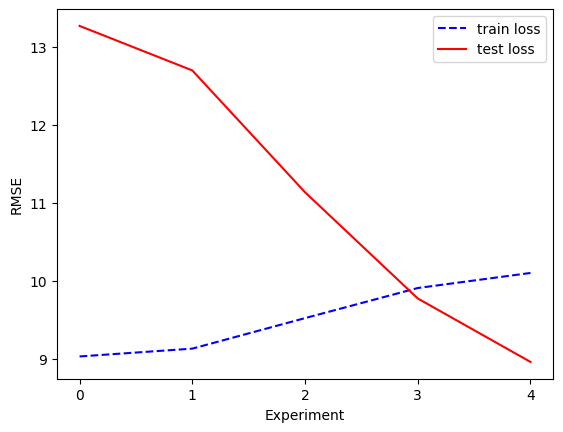

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(k_fold_splits), rmse_train, "b--", label = "train loss")
plt.plot(range(k_fold_splits), rmse_test, "r", label = "test loss")
ax = fig.gca()
ax.set_xticks(range(k_fold_splits))
plt.xlabel("Experiment")
plt.ylabel("RMSE")
plt.legend()
plt.show()

From the plot, we can pick up the model with the smallest error. We will use that one as baseline and compare it with predictions from LSTM.

In [26]:
#y_test = 
# dimensionality reduction with the RGDR operator used by the best model
clusters_test = RGDRs[np.argmax(rmse_test)].transform(precursor_field_sel[-test_samples:])
# predict with the best model
predictions_baseline = models[np.argmax(rmse_test)].predict(clusters_test.isel(i_interval=0))

Let's plot all predictions and the ground truth and check the errors.

The MSE of LSTM forecasts is 2.626
The MSE of baseline ridge forecasts is 3.039


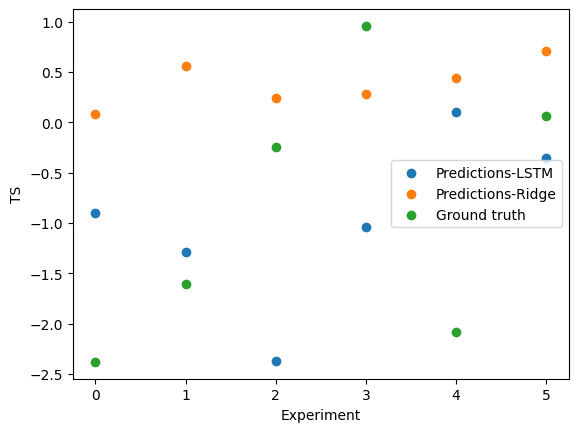

In [27]:
print(
    f"The MSE of LSTM forecasts is {mean_squared_error(ground_truth, np.concatenate(predictions)):.3f}"
)
print(
    f"The MSE of baseline ridge forecasts is {mean_squared_error(ground_truth, predictions_baseline):.3f}"
)

fig = plt.figure()
plt.scatter(instances, np.concatenate(predictions), label="Predictions-LSTM")
plt.scatter(instances, predictions_baseline, label="Predictions-Ridge")
plt.scatter(instances, ground_truth, label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()